In [1]:
import os
import os.path as osp

import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMG_DIR = "./imgs/custom/"

In [3]:
files = sorted([ osp.join(IMG_DIR, f) for f in os.listdir(IMG_DIR) ])
print("Number of images:", len(files))

Number of images: 8


# Display all image taken with different views

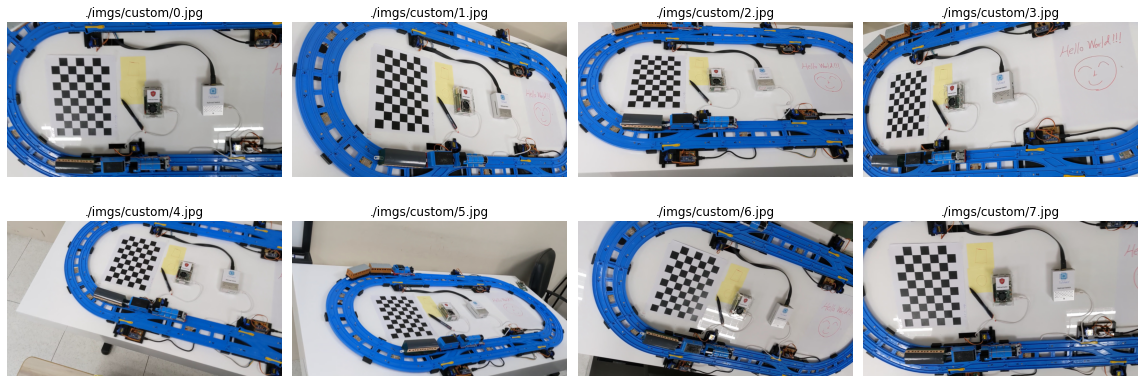

In [4]:
nrows = 2
ncols = len(files) // nrows
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 6))

for i in range(nrows):
    for j in range(ncols):
        fname = files[i*ncols+j]
        img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
        axes[i][j].set_title(fname)
        axes[i][j].imshow(img)
        axes[i][j].set_axis_off()

plt.tight_layout()

# Load pre-estimated camera parameters

In [5]:
with open("../output/custom.pkl", "rb") as f:
    pixel4a = pickle.load(f)
    
intrinsic = pixel4a['intrinsic']['matrix']
extrinsics = pixel4a['extrinsics']

print("Intrinsic", intrinsic.shape)
print(intrinsic)

Intrinsic (3, 3)
[[1.86218340e+03 0.00000000e+00 1.04632465e+03]
 [0.00000000e+00 1.83796768e+03 5.72547867e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


# Estimated reconstruction error from 3D to 2D

## 3D chessboard coordinates

In [6]:
PATTERN_SIZE = (9, 6)

pattern_points = np.zeros((np.prod(PATTERN_SIZE), 3), np.float32)
pattern_points[:, :2] = np.indices(PATTERN_SIZE).T.reshape(-1, 2)
pattern_points *= 0.025 # m
pattern_points = pattern_points.T

world_homogeneous = np.vstack([pattern_points, np.ones(pattern_points.shape[1])])
print(world_homogeneous.shape)

(4, 54)


## Project 3D points to 2D points

In [67]:
fnames = sorted(list(extrinsics.keys()))

rec_results = []
for i, fname in enumerate(fnames):
    R, T = extrinsics[fname]['R'], extrinsics[fname]['T']
    extrinsic = np.zeros((4, 4))
    extrinsic[:3, :3] = R
    extrinsic[:3, -1] = T.reshape(-1)
    extrinsic[-1, -1] = 1
    
    # Camera projection: 3D => 2D
    rec_cam_coords = (extrinsic @ world_homogeneous)
    # print(np.mean(rec_cam_coords[-2, :]))
    if i == 0:
        print(rec_cam_coords[:, 0])
    rec_img_coords = (rec_cam_coords / rec_cam_coords[-2, :]) # Divide Z depth
    img_homogeneous = np.vstack([rec_img_coords[:2],
                                 np.ones(rec_img_coords.shape[1])])
    rec_pix_coords = intrinsic @ img_homogeneous
    rec_corners = rec_pix_coords[:2].T.reshape(-1, 1, 2)
    
    # Save reconstructed corners
    rec_results.append(rec_corners)

[-0.29533709  0.0764704   0.84551079  1.        ]


## Estimate reconstruction error
- predicted output: 2D chessboard coordinates projected from 3D space
- ground truth: 2D chessboard coordinates detected by OpenCV algorithm

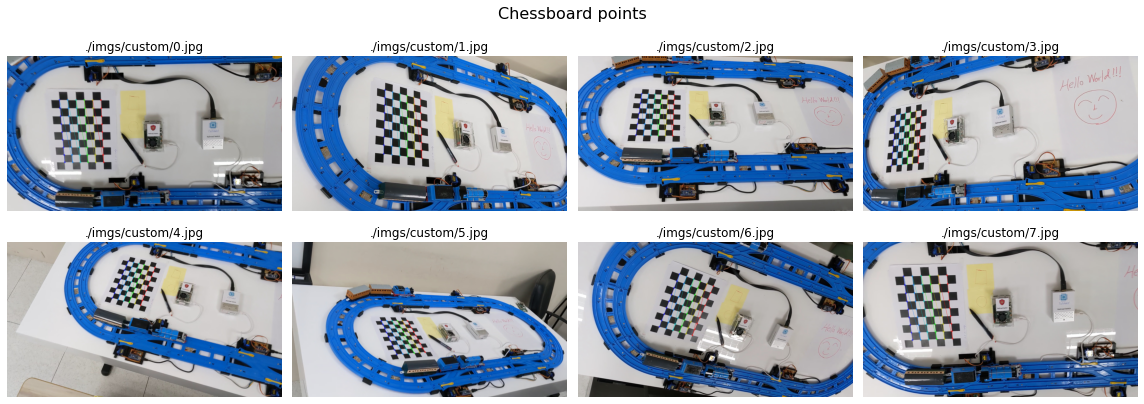

In [8]:
nrows = 2
ncols = len(files) // nrows
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 6))
fig.suptitle("Chessboard points", fontsize=16)

results = []
for i in range(nrows):
    for j in range(ncols):
        fname = files[i*ncols+j]
        img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        found, corners = cv2.findChessboardCorners(gray, PATTERN_SIZE)
        if found:
            term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
            cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), term)
        results.append(corners)
        
        img = cv2.drawChessboardCorners(img, PATTERN_SIZE, corners, found)
        axes[i][j].set_title(fname)
        axes[i][j].imshow(img)
        axes[i][j].set_axis_off()
        
plt.tight_layout()

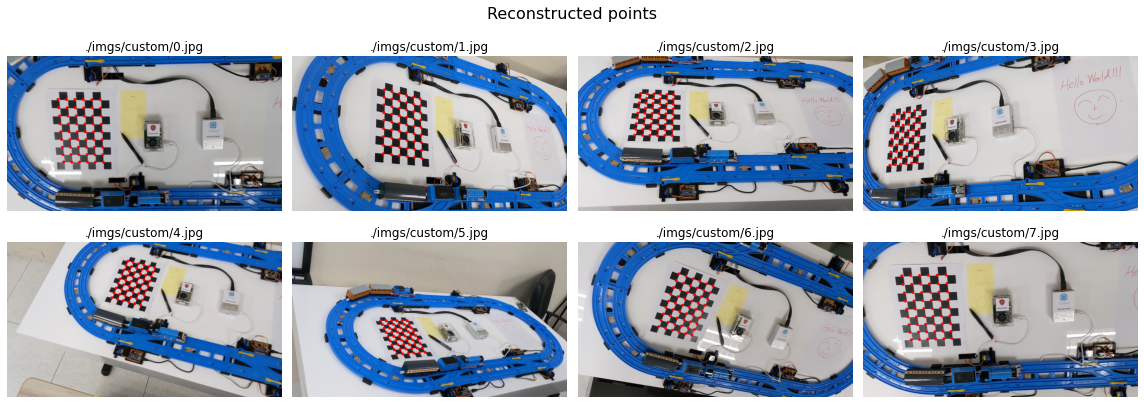

In [9]:
nrows = 2
ncols = len(files) // nrows
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 6))
fig.suptitle("Reconstructed points", fontsize=16)

for i in range(nrows):
    for j in range(ncols):
        fname = files[i*ncols+j]
        img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
        rec_corners = rec_results[i*ncols+j]
        img = cv2.polylines(img.copy(), rec_corners.astype(np.int32), True, (255, 0, 0), thickness=20)
        axes[i][j].set_title(fname)
        axes[i][j].imshow(img)
        axes[i][j].set_axis_off()
        
plt.tight_layout()

## Show reconstruction error of each view

In [10]:
rec = np.array(rec_results)
orig = np.array(results)

# Average error for all 54 chessboard coordinates
diff = np.sqrt((rec - orig)**2).reshape(8, -1)
diff = diff.mean(axis=1)

for i, fname in enumerate(files):
    print("[{}] Error: {}".format(fname, diff[i]))

[./imgs/custom/0.jpg] Error: 3.5313116573055816
[./imgs/custom/1.jpg] Error: 1.5604770736249232
[./imgs/custom/2.jpg] Error: 3.703350537993887
[./imgs/custom/3.jpg] Error: 5.947757260123182
[./imgs/custom/4.jpg] Error: 1.3381521571912454
[./imgs/custom/5.jpg] Error: 1.2230841973861015
[./imgs/custom/6.jpg] Error: 1.78840937834862
[./imgs/custom/7.jpg] Error: 4.443232546245293


#  Estimated reconstruction error from 2D to 3D

In [15]:
# Ground truth object
PATTERN_SIZE = (9, 6)

pattern_points = np.zeros((np.prod(PATTERN_SIZE), 3), np.float32)
pattern_points[:, :2] = np.indices(PATTERN_SIZE).T.reshape(-1, 2)
pattern_points *= 0.025 # m
pattern_points = pattern_points.T

print(pattern_points.shape)

(3, 54)


In [19]:
chess_points = np.array(results)

keys = sorted(extrinsics.keys())

['input/custom/0.jpg', 'input/custom/1.jpg', 'input/custom/2.jpg', 'input/custom/3.jpg', 'input/custom/4.jpg', 'input/custom/5.jpg', 'input/custom/6.jpg', 'input/custom/7.jpg']
['./imgs/custom/0.jpg', './imgs/custom/1.jpg', './imgs/custom/2.jpg', './imgs/custom/3.jpg', './imgs/custom/4.jpg', './imgs/custom/5.jpg', './imgs/custom/6.jpg', './imgs/custom/7.jpg']


In [69]:
chess_coords = chess_points[0]

pix_coords = np.transpose(chess_coords, [2, 1, 0]).reshape(2, -1)
pix_coords = np.vstack([pix_coords, np.ones(pix_coords.shape[1])])
print(pix_coords.shape)

int_coords = np.linalg.inv(intrinsic) @ pix_coords
cam_coords = np.ones((4, 54))
cam_coords[:2] = int_coords[:2]
cam_coords[2] = np.ones(int_coords.shape[1])*0.84551079
print(cam_coords[:, 0])
print(cam_coords.shape)

R = np.zeros((4, 4))
R[:3, :3] = extrinsics['input/custom/0.jpg']['R']
R[-1, -1] = 1

T = np.zeros((4, 4))
T[:3, -1] = extrinsics['input/custom/0.jpg']['T'].reshape(-1)
T[0, 0] = 1
T[1, 1] = 1
T[2, 2] = 1
T[3, 3] = 1
extrinsic = R @ T
world_coords = np.linalg.inv(extrinsic) @ cam_coords
print(world_coords.shape)

print(world_coords[:, 0])

(3, 54)
[-0.34560972  0.09105077  0.84551079  1.        ]
(4, 54)
(4, 54)
[-0.02231985 -0.40658899 -0.05006085  1.        ]
